# Emotion recognition using Deep Recurrent Neural Network

## Datasource 
original source: https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

cloned version for easy access: https://umbc.app.box.com/s/dwd0cjorv2mgza78x69l9ptiborzko01


(Note: For this project we are going to use `data_preprocessed_python.zip` file.)

Instructions:
- Download the `data_preprocessed_python.zip` file and extract it inside `data` folder
- Download the `participant_ratings.csv` file and place in inside `data/DEAP/labels` folder
- Run `pip install -r requirements.txt`
- Run `python  ./scripts/preprocess.py` (This will preprocess the raw data and create `bio_normalized` folder to store the preprocessed data)

In [20]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 🧠 DEAP EEG Dataset Preprocessing Pipeline

To prepare the DEAP EEG dataset for deep learning models, we implement a customized preprocessing pipeline using PyTorch. This includes normalization, label transformation into discrete classes, dataset splitting, and data augmentation.

---

### 🔍 Preprocessing Overview

#### 1. **Input Data Structure**
- EEG signals are stored as `.npy` files in the shape of `[32, 128]` (1-second segment at 128 Hz).
- Each subject has 40 trials, each trial is divided into 60 segments.
- Labels (Valence, Arousal) are retrieved from a CSV file and mapped using `(subject_id, trial_id)`.

---

#### 2. **Normalization**
- Each EEG segment is converted to `float32` and normalized per channel.
- Z-score normalization is implicitly applied during training.
- Additional filtering or preprocessing (e.g., bandpass filter) can be included before loading if required.

---

### 3. **Label Conversion**
Labels are determined based on the `label_type` parameter:

- **Valence-only**: Binary classification  
  - `0` if valence < 5  
  - `1` if valence ≥ 5  

- **Arousal-only**: Binary classification  
  - `0` if arousal < 5  
  - `1` if arousal ≥ 5  

- **Combined (4-Class Classification)**: Based on valence and arousal combinations:

| Valence | Arousal | Emotion Class     | Label |
|---------|---------|-------------------|-------|
| High    | High    | Excited/Happy     | 0     |
| High    | Low     | Relaxed           | 1     |
| Low     | High    | Angry             | 2     |
| Low     | Low     | Sad               | 3     |

> **Note**: High = score ≥ 5, Low = score < 5

---

### 4. **Dataset Construction**
- EEG segments are loaded using `load_deap_dataset()` for all selected subjects and trials.
- Each EEG segment is stored along with its:
  - Preprocessed EEG tensor
  - Classification label (0–3)
  - Raw valence/arousal score

- The dataset is split using `train_test_split()`:
  - Stratified sampling is used for class balance
  - Default: 70% training, 30% validation

---

### 5. **Data Augmentation**
- The custom `DEAP` PyTorch `Dataset` class supports optional augmentation.
- If `augment=True`, EEG segments are randomly modified using `augment_eeg()` (e.g., segment mixing, noise injection).
- Augmentation is only applied during training.

---

### ✅ Dataset Generation Functions

- `create_train_val_datasets(label_type, label_path, bio_path, subjects, ...)`
  - Splits the full dataset into train/val.
  - Returns `train_dataset`, `val_dataset`.
  - Optionally saves `.pt` files.

- `create_test_dataset(label_type, label_path, bio_path, subjects)`
  - Returns the test dataset for held-out subjects.

---

This pipeline ensures that EEG inputs are properly structured, normalized, and split to facilitate effective training of deep learning models on the DEAP dataset.


In [1]:
import pandas as pd
import numpy as np
from utils.torch_utils import initialize_torch
from configs.runtime import device
initialize_torch()

Using device: cuda


In [ ]:
from datasets.deap import create_train_val_datasets

train_val_eeg, val_val_eeg = create_train_val_datasets(
    label_type='valence',
    label_path='./data/DEAP/labels',
    bio_path='./data/DEAP/bio_normalized',
    subjects=list(range(1,31)),
    save_datasets=True,
    dataset_path='datasets/valence_temp'
)

train_aro_eeg, val_aro_eeg = create_train_val_datasets(
    label_type='arousal',
    label_path='./data/DEAP/labels',
    bio_path='./data/DEAP/bio_normalized',
    subjects=list(range(1,31)),
    save_datasets=True,
    dataset_path='datasets/arousal_temp'
)

Loading subject 1:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 2:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 1:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 2:   0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
len(train_val_eeg), len(val_val_eeg)

(3024, 1296)

In [5]:
len(train_aro_eeg), len(val_aro_eeg)

(2688, 1152)

In [7]:
from collections import Counter

def print_label_distribution(dataset, name):
    labels = []
    for i in range(len(dataset)):
        data = dataset[i]
        if data is not None:
            _, label, _ = data
            labels.append(int(label.item()))
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"{name} label distribution:")
    for label, count in sorted(counter.items()):
        print(f"  Label {label}: {count} samples ({count/total:.2%})")
    print()

# Call the function on each dataset
print_label_distribution(train_val_eeg, "Train")
print_label_distribution(val_val_eeg, "Validation")

Train label distribution:
  Label 0: 1512 samples (50.00%)
  Label 1: 1512 samples (50.00%)

Validation label distribution:
  Label 0: 648 samples (50.00%)
  Label 1: 648 samples (50.00%)



## Let's plot distribution of Valance and Arousel

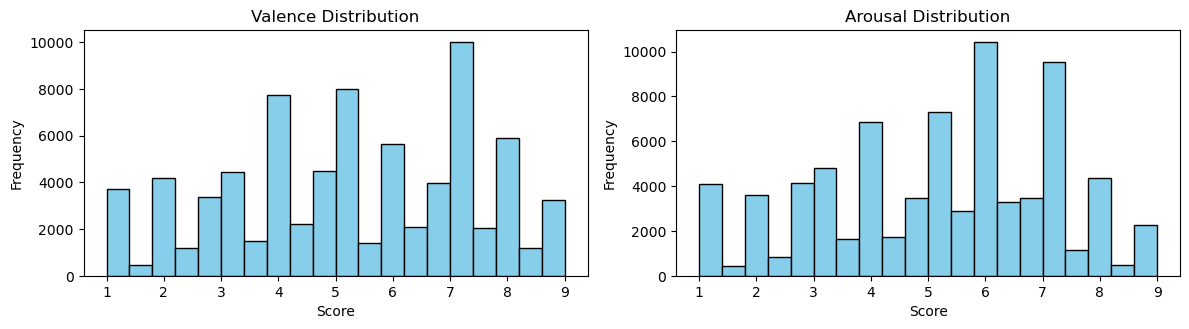

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# For 32 subjects × 40 trials × 60 segments


def plot_label_histograms(labels_csv = "./data/DEAP/labels/participant_ratings.csv"):
    val_aro_list = []
    df  = pd.read_csv(labels_csv)
    for _, row in df.iterrows():
        val = row['Valence']
        aro = row['Arousal']
        val_aro_list.extend([[val, aro]] * 60)  # Repeat for 60 segments

    valence_arousal_array = np.array(val_aro_list)
    label_names = ['Valence', 'Arousal']
    plt.figure(figsize=(12, 6))
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        plt.hist(valence_arousal_array[:, i], bins=20, color='skyblue', edgecolor='black')
        plt.title(f'{label_names[i]} Distribution')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
    plt.tight_layout()

plot_label_histograms()

## Plotting emotion distribution

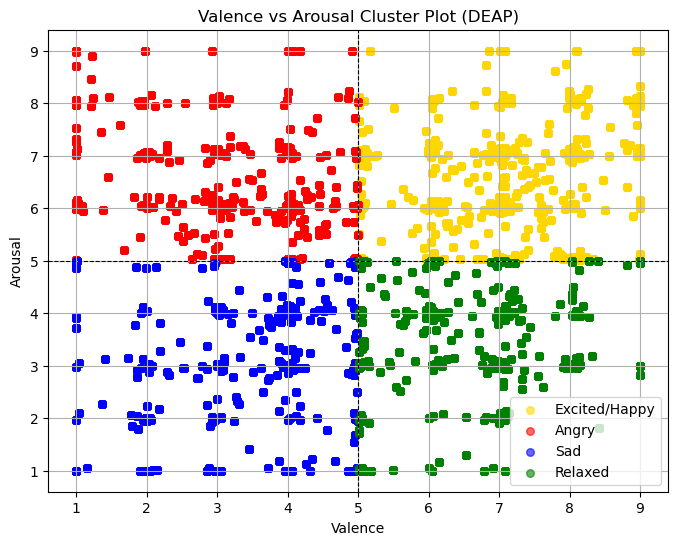

In [9]:
def plot_emotions(labels_csv = "./data/DEAP/labels/participant_ratings.csv"):
    val_aro_list = []
    df  = pd.read_csv(labels_csv)
    for _, row in df.iterrows():
        val = row['Valence']
        aro = row['Arousal']
        val_aro_list.extend([[val, aro]] * 60)  # Repeat for 60 segments

    valence_arousal_array = np.array(val_aro_list)
    valence = valence_arousal_array[:, 0]
    arousal = valence_arousal_array[:, 1]

    def create_4class_labels(valence, arousal):
        classes = []
        for v, a in zip(valence, arousal):
            if v > 5 and a > 5:
                classes.append(0)  # Excited/Happy
            elif v <= 5 and a > 5:
                classes.append(1)  # Angry
            elif v <= 5 and a <= 5:
                classes.append(2)  # Sad
            else:
                classes.append(3)  # Relaxed
        return np.array(classes)

    emotion_classes = create_4class_labels(valence, arousal)
    class_names = ["Excited/Happy", "Angry", "Sad", "Relaxed"]
    colors = ["gold", "red", "blue", "green"]

    # Plot
    plt.figure(figsize=(8, 6))
    for cls in range(4):
        idx = emotion_classes == cls
        plt.scatter(valence[idx], arousal[idx], label=class_names[cls], alpha=0.6, s=30, color=colors[cls])

    plt.axhline(y=5, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    plt.title("Valence vs Arousal Cluster Plot (DEAP)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_emotions()

## Plotting signals from first 4 channels for first trial

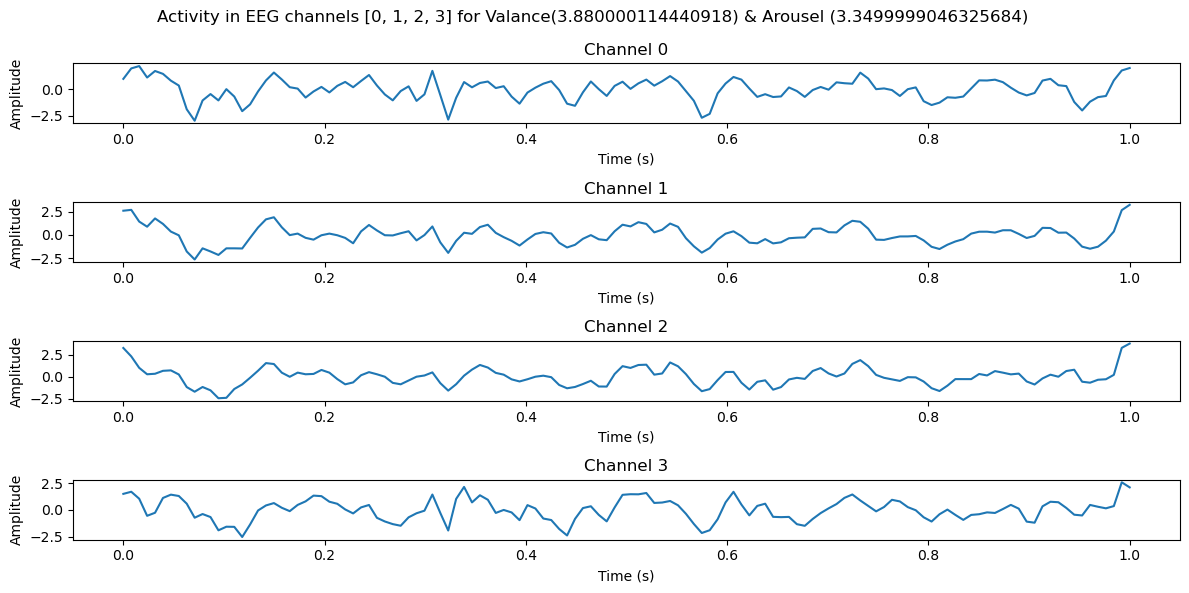

In [10]:
def plot_eeg_sample(data, labels, channels=[0, 1, 2]):
    seconds = 1
    sampling_rate = 128
    time = np.linspace(0, seconds, seconds * sampling_rate)
    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(channels):
        plt.subplot(len(channels), 1, i + 1)
        plt.plot(time, data[ch, :seconds * sampling_rate])
        plt.title(f'Channel {ch}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    plt.suptitle(f"Activity in EEG channels {channels} for Valance({labels[0]}) & Arousel ({labels[1]}) ")
    plt.tight_layout()
    plt.show()

data = train_val_eeg[0][0]
labels = train_val_eeg[0][2]
# 
plot_eeg_sample(data, labels, channels=[0,1,2,3])


## Model initialization

For this project we decided to use modified Chrononet which is a A Deep Recurrent Neural Network

Original model:

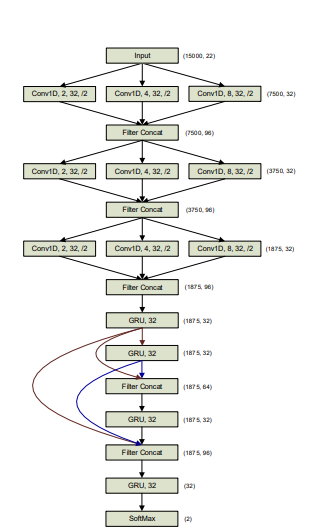

Reference : (https://arxiv.org/pdf/1802.00308)

In [11]:
from models.chrononet import ChronoNet
from torch import nn
import torch
from utils.early_stopping import EarlyStopping
from scripts.train import run_training

### 📊 ChronoNet Hyperparameters – Arousal Classification

| Hyperparameter         | Value                                                 |
|------------------------|-------------------------------------------------------|
| Model                  | ChronoNet                                              |
| Input Channels         | 32                                                    |
| Conv Output Channels   | 32                                                    |
| GRU Hidden Size        | 64                                                    |
| Loss Function          | BCEWithLogitsLoss                                     |
| Optimizer              | AdamW                                                 |
| Learning Rate          | 1e-3                                                  |
| Weight Decay           | 1e-4                                                  |
| LR Scheduler           | ReduceLROnPlateau (patience=3, mode='min')           |
| Early Stopping         | Patience = 20 (mode='max')                            |
| Batch Size             | 32                                                    |
| Epochs                 | 100                                                   |
| Checkpoint Path        | `checkpoints/chrononet_aro`                           |
| Result CSV             | `results/history_aro.csv`                             |

In [12]:
model = ChronoNet(in_channels=32, conv_out_channels=32, gru_hidden_size=64, is_binary=True, num_classes=2,)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) 
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
early_stopping = EarlyStopping(patience=20, mode='max')

trained_model_aro, history_aro = run_training(
    model=model,
    train_dataset=train_aro_eeg,
    val_dataset=val_aro_eeg,
    loss_fn=loss_fn,
    optimizer=optimizer,
    lr_schedule=lr_schedule,
    early_stopping=early_stopping,
    device=device,
    batch_size=32,
    epochs=100,
    model_destination='checkpoints/chrononet_aro',
)
# Saving results
history_aro.to_csv('results/history_aro.csv')

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]

Training...:   0%|          | 0/84 [00:00<?, ?it/s]

Validating..:   0%|          | 0/36 [00:00<?, ?it/s]


⛔ Early stopping triggered at epoch 60. Stopping training.

🏆 Best Validation Accuracy: 0.5703
Best model loaded from checkpoints/chrononet_aro_best.pth


### 📊 ChronoNet Hyperparameters – Valence Classification

| Hyperparameter         | Value                                                 |
|------------------------|-------------------------------------------------------|
| Model                  | ChronoNet                                              |
| Input Channels         | 32                                                    |
| Conv Output Channels   | 32                                                    |
| GRU Hidden Size        | 64                                                    |
| Loss Function          | BCEWithLogitsLoss                                     |
| Optimizer              | AdamW                                                 |
| Learning Rate          | 1e-3                                                  |
| Weight Decay           | 1e-4                                                  |
| LR Scheduler           | ReduceLROnPlateau (patience=3, mode='min')           |
| Early Stopping         | Patience = 20 (mode='max')                            |
| Batch Size             | 32                                                    |
| Epochs                 | 100                                                   |
| Checkpoint Path        | `checkpoints/chrononet_val`                           |
| Result CSV             | `results/history_val.csv`                             |


In [13]:
model = ChronoNet(in_channels=32, conv_out_channels=32, gru_hidden_size=64, is_binary=True, num_classes=2,)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) 
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
early_stopping = EarlyStopping(patience=20, mode='max')

trained_model_val, history_val = run_training(
    model=model,
    train_dataset=train_val_eeg,
    val_dataset=val_val_eeg,
    loss_fn=loss_fn,
    optimizer=optimizer,
    lr_schedule=lr_schedule,
    early_stopping=early_stopping,
    device=device,
    batch_size=32,
    epochs=100,
    model_destination='checkpoints/chrononet_val',
)

# Saving results
history_val.to_csv('results/history_val.csv')

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]

Training...:   0%|          | 0/94 [00:00<?, ?it/s]

Validating..:   0%|          | 0/41 [00:00<?, ?it/s]


⛔ Early stopping triggered at epoch 22. Stopping training.

🏆 Best Validation Accuracy: 0.5895
Best model loaded from checkpoints/chrononet_val_best.pth


### Training Report :

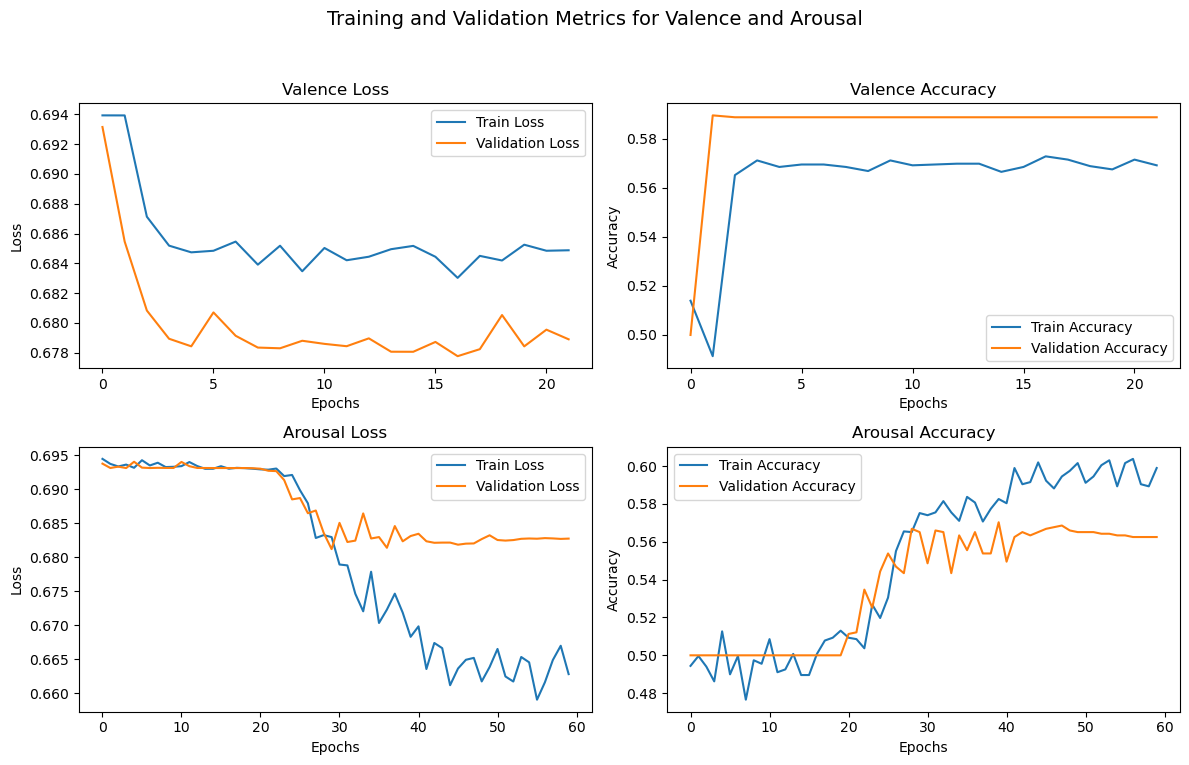

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Training and Validation Metrics for Valence and Arousal', fontsize=14)

# Valence Loss
axs[0, 0].plot(history_val['train_loss'], label='Train Loss')
axs[0, 0].plot(history_val['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Valence Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Valence Accuracy
axs[0, 1].plot(history_val['train_acc'], label='Train Accuracy')
axs[0, 1].plot(history_val['val_acc'], label='Validation Accuracy')
axs[0, 1].set_title('Valence Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Arousal Loss
axs[1, 0].plot(history_aro['train_loss'], label='Train Loss')
axs[1, 0].plot(history_aro['val_loss'], label='Validation Loss')
axs[1, 0].set_title('Arousal Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Arousal Accuracy
axs[1, 1].plot(history_aro['train_acc'], label='Train Accuracy')
axs[1, 1].plot(history_aro['val_acc'], label='Validation Accuracy')
axs[1, 1].set_title('Arousal Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Results

### Testing network on Subjects number **31** and **32**

In [ ]:
from scripts.test import predict
from datasets.deap import DEAP, load_deap_dataset

test_valence_data, test_valence_labels, test_valence_values  = load_deap_dataset(
    label_type='valence',
    label_path='./data/DEAP/labels',
    bio_path='./data/DEAP/bio_normalized',
    subjects=list(range(31, 33))
)
test_valence_dataset = DEAP(test_valence_data, torch.tensor(test_valence_labels, dtype=torch.long), test_valence_values, augment=False)

test_arousal_data, test_arousal_labels, test_arousal_values = load_deap_dataset(
    label_type='arousal',
    label_path='./data/DEAP/labels',
    bio_path='./data/DEAP/bio_normalized',
    subjects=list(range(31, 33))
)
test_arousal_dataset = DEAP(test_arousal_data, torch.tensor(test_arousal_labels, dtype=torch.long), test_arousal_values, augment=False)



pred_val, prob_val, true_val  = predict(model, test_valence_dataset, device, batch_size=64, return_probs=True)

# from scripts.test import predict
pred_aro, prob_aro, true_aro  = predict(model, test_arousal_dataset, device, batch_size=64, return_probs=True)

Loading subject 31:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 32:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 31:   0%|          | 0/40 [00:00<?, ?it/s]

Loading subject 32:   0%|          | 0/40 [00:00<?, ?it/s]

Predicting...:   0%|          | 0/75 [00:00<?, ?it/s]

Predicting...:   0%|          | 0/75 [00:00<?, ?it/s]

### Arousal Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_aro, true_aro, target_names=['Low Arousal', 'High Arousal']))

              precision    recall  f1-score   support

 Low Arousal       0.00      0.00      0.00         0
High Arousal       1.00      0.60      0.75      4800

    accuracy                           0.60      4800
   macro avg       0.50      0.30      0.37      4800
weighted avg       1.00      0.60      0.75      4800



c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Valence Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_val, true_val, target_names=['Low Valence', 'High Valence']))

              precision    recall  f1-score   support

 Low Valence       0.00      0.00      0.00         0
High Valence       1.00      0.57      0.73      4800

    accuracy                           0.57      4800
   macro avg       0.50      0.29      0.37      4800
weighted avg       1.00      0.57      0.73      4800



c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\devdp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

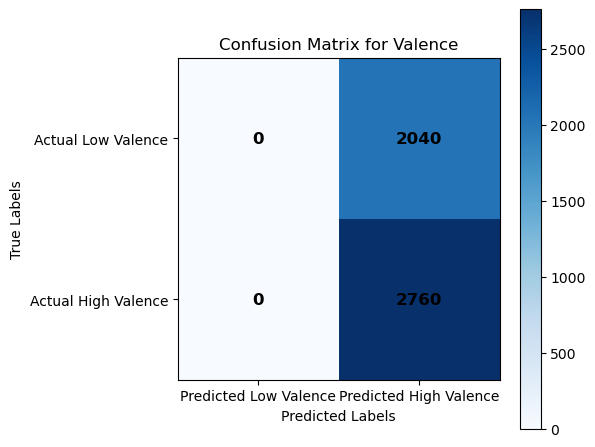

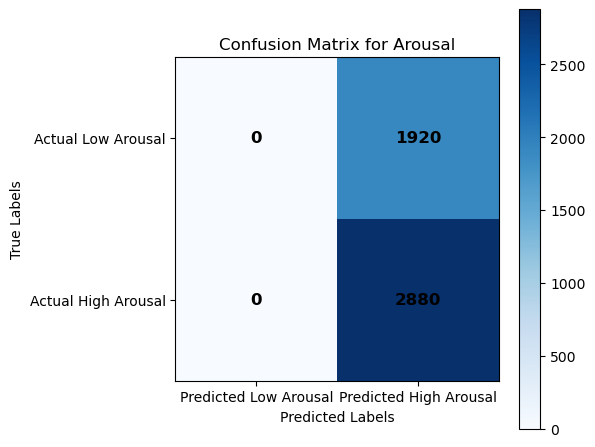

In [ ]:
from scripts.metrics import plot_confusion_matrix

plot_confusion_matrix(
    true_val, pred_val,
    class_names=['Low Valence', 'High Valence'],
    title='Confusion Matrix for Valence'
)

plot_confusion_matrix(
    true_aro, pred_aro,
    class_names=['Low Arousal', 'High Arousal'],
    title='Confusion Matrix for Arousal'
)